### Business Goal 4: Predict the outcome of upcoming games based on the sentiment or volume of the discussions before the games.

In [4]:
# Setup - Run only once per Kernel App
# %conda install openjdk -y

# # install PySpark
# %pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [36]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as f
from pyspark.sql.functions import when, col, desc, regexp_replace, lower, udf, to_date
from pyspark.sql import DataFrame
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, VectorAssembler, StringIndexer
from pyspark.sql.types import BooleanType, StringType, DateType, IntegerType, DoubleType
from pyspark.ml import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### Read in data

In [6]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.executor.memory", "10g")
    .config("spark.driver.memory", "10g")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1d344539-7a74-4af4-a5fd-a5c221e7ef96;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 330ms :: artifacts dl 24ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [7]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=3600,
)

# s3 paths
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_logs = f"spark_logs"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 2.01 s, sys: 159 ms, total: 2.17 s
Wall time: 2.42 s


In [8]:
%%time
df_path = f"reddit_soccer_data/"
s3_path = f"s3a://{bucket}/{df_path}"
print(f"reading submissions from {s3_path}")
df = spark.read.parquet(s3_path, header=True)
print(f"shape of the dataframe is {df.count():,}x{len(df.columns)}")

reading submissions from s3a://sagemaker-us-east-1-634977863454/reddit_soccer_data/


23/12/01 01:54:11 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the dataframe is 5,617,852x9
CPU times: user 39.7 ms, sys: 4.61 ms, total: 44.3 ms
Wall time: 1min 5s


### Retrieve data from 3 most popular clubs

In [9]:
# Select only the required columns
selected_df = df.select('author_flair_text', 'body', 'created_utc', 'score', 'subreddit')

# DataFrame for Arsenal
df_arsenal = selected_df.filter(
    (col('subreddit') == 'Gunners') | 
    ((col('subreddit') == 'soccer') & (col('author_flair_text') == ':Arsenal:'))
)

# DataFrame for Manchester United
df_man_united = selected_df.filter(
    (col('subreddit') == 'reddevils') | 
    ((col('subreddit') == 'soccer') & (col('author_flair_text') == ':Manchester_United:'))
)

df_chelsea = selected_df.filter(
    (col('subreddit') == 'chelseafc') | 
    ((col('subreddit') == 'soccer') & (col('author_flair_text') == ':Chelsea:'))
)

### Cleaning texts on the created dataframes:

In [10]:
# Removing non-alphanumeric characters
df_arsenal = df_arsenal.withColumn('clean_body', regexp_replace('body', '[^A-Za-z0-9\s]+', ''))
df_man_united = df_man_united.withColumn('clean_body', regexp_replace('body', '[^A-Za-z0-9\s]+', ''))
df_chelsea = df_chelsea.withColumn('clean_body', regexp_replace('body', '[^A-Za-z0-9\s]+', ''))

# Converting to lowercase
df_arsenal = df_arsenal.withColumn('clean_body', lower(col('clean_body')))
df_man_united = df_man_united.withColumn('clean_body', lower(col('clean_body')))
df_chelsea = df_chelsea.withColumn('clean_body', lower(col('clean_body')))

# Tokenize text
tokenizer = Tokenizer(inputCol='clean_body', outputCol='words')
df_arsenal = tokenizer.transform(df_arsenal)

tokenizer = Tokenizer(inputCol='clean_body', outputCol='words')
df_man_united = tokenizer.transform(df_man_united)

tokenizer = Tokenizer(inputCol='clean_body', outputCol='words')
df_chelsea = tokenizer.transform(df_chelsea)

# Remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_arsenal = remover.transform(df_arsenal)

remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_man_united = remover.transform(df_man_united)

remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_chelsea = remover.transform(df_chelsea)

In [11]:
def filter_words(words_list):
    return words_list == ['deleted'] or words_list == []

# Define the UDF for Filter Words
filter_words_udf = udf(filter_words, BooleanType())

df_arsenal = df_arsenal.withColumn('remove_row', filter_words_udf(col('filtered_words')))
df_arsenal = df_arsenal.filter(col('remove_row') == False)
df_arsenal = df_arsenal.drop('remove_row')

df_man_united = df_man_united.withColumn('remove_row', filter_words_udf(col('filtered_words')))
df_man_united = df_man_united.filter(col('remove_row') == False)
df_man_united = df_man_united.drop('remove_row')

df_chelsea = df_chelsea.withColumn('remove_row', filter_words_udf(col('filtered_words')))
df_chelsea = df_chelsea.filter(col('remove_row') == False)
df_chelsea = df_chelsea.drop('remove_row')

# Define the UDF for Concatting
concat_udf = udf(lambda words: ' '.join(words), StringType())

df_arsenal = df_arsenal.withColumn("concatenated_text", concat_udf(col("filtered_words")))
df_arsenal = df_arsenal.drop('body', 'clean_body', 'words', 'filtered_words')

df_man_united = df_man_united.withColumn("concatenated_text", concat_udf(col("filtered_words")))
df_man_united = df_man_united.drop('body', 'clean_body', 'words', 'filtered_words')

df_chelsea = df_chelsea.withColumn("concatenated_text", concat_udf(col("filtered_words")))
df_chelsea = df_chelsea.drop('body', 'clean_body', 'words', 'filtered_words')

In [12]:
df_arsenal = df_arsenal.withColumn('date', to_date('created_utc'))
df_arsenal = df_arsenal.drop('created_utc')

df_man_united = df_man_united.withColumn('date', to_date('created_utc'))
df_man_united = df_man_united.drop('created_utc')

df_chelsea = df_chelsea.withColumn('date', to_date('created_utc'))
df_chelsea = df_chelsea.drop('created_utc')

### Merge the comments with the matches results dataframe

In [13]:
matches = pd.read_csv("./top_5_teams_scores.csv")
matches['date'] = pd.to_datetime(matches['date'], format='%m/%d/%Y')

df_matches = spark.createDataFrame(matches)

# Convert the 'date' column in matches_spark to date type if it's not already
df_matches = df_matches.withColumn("date", df_matches["date"].cast(DateType()))

df_matches.show(5)

+-------+----------+----------+------+--------+-------+--------------+
|   team|  opponent|      date|scored|conceded|outcome|    tournament|
+-------+----------+----------+------+--------+-------+--------------+
|Arsenal| Newcastle|2023-01-03|     0|       0|   draw|Premier League|
|Arsenal|Oxford Utd|2023-01-09|     3|       0|    win|        FA Cup|
|Arsenal| Tottenham|2023-01-15|     2|       0|    win|Premier League|
|Arsenal|Man United|2023-01-22|     3|       2|    win|Premier League|
|Arsenal|  Man City|2023-01-27|     0|       1|   loss|        FA Cup|
+-------+----------+----------+------+--------+-------+--------------+
only showing top 5 rows



In [14]:
df_arsenal_matches = df_matches.filter(df_matches['team'] == 'Arsenal')
df_arsenal_merged = df_arsenal.join(df_arsenal_matches, on='date', how='inner')

df_arsenal_merged = df_arsenal_merged.drop('author_flair_text', 'subreddit', 'team', 'opponent', 'scored', 'conceded', 'tournament')
# df_arsenal_merged.cache()

In [15]:
df_man_united_matches = df_matches.filter(df_matches['team'] == 'Man United')
df_man_united_merged = df_man_united.join(df_man_united_matches, on='date', how='inner')

df_man_united_merged = df_man_united_merged.drop('author_flair_text', 'subreddit', 'team', 'opponent', 'scored', 'conceded', 'tournament')
# df_man_united_merged.cache()

In [16]:
df_chelsea_matches = df_matches.filter(df_matches['team'] == 'Chelsea')
df_chelsea_merged = df_chelsea.join(df_chelsea_matches, on='date', how='inner')

df_chelsea_merged = df_chelsea_merged.drop('author_flair_text', 'subreddit', 'team', 'opponent', 'scored', 'conceded', 'tournament')
# df_chelsea_merged.cache()

### Create the final dataframe that will be used to perform maching learning. The features will be the comment body and score, where the outcome will be the label.

In [17]:
df_ml = df_arsenal_merged.union(df_man_united_merged).union(df_chelsea_merged)
df_ml = df_ml.dropna()
# Filter out rows where 'outcome' is 'draw'
df_ml = df_ml.filter(df_ml['outcome'] != 'draw')
df_ml = df_ml.orderBy('date')
df_ml.cache()

DataFrame[date: date, score: bigint, concatenated_text: string, outcome: string]

In [18]:
df_ml.show(10)

+----------+-----+--------------------+-------+
|      date|score|   concatenated_text|outcome|
+----------+-----+--------------------+-------+
|2023-01-03|    7|bournemouth win  ...|    win|
|2023-01-03|    3|problem city like...|    win|
|2023-01-03|   20|big beat city ars...|    win|
|2023-01-03|    4|              season|    win|
|2023-01-03|    9|glad sign alex sa...|    win|
|2023-01-03|   40|penalty pulling s...|    win|
|2023-01-03|    7|bournemouth great...|    win|
|2023-01-03|    8|cas bit early mak...|    win|
|2023-01-03|   40|mikel disappointi...|    win|
|2023-01-03|   54|happy new year wa...|    win|
+----------+-----+--------------------+-------+
only showing top 10 rows



### Spark ML

In [19]:
df_ml.printSchema()

root
 |-- date: date (nullable = true)
 |-- score: long (nullable = true)
 |-- concatenated_text: string (nullable = true)
 |-- outcome: string (nullable = true)



In [20]:
df_ml.groupBy('outcome').count().show()

+-------+------+
|outcome| count|
+-------+------+
|    win|431555|
|   loss|199280|
+-------+------+



There are 2 outcomes as the label of this machine learning task. Logistic Regression would be a good starting point.

#### Step 1: text vectorization

In [21]:
tokenizer = Tokenizer(inputCol="concatenated_text", outputCol="words")
df_words = tokenizer.transform(df_ml)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
df_tf = hashingTF.transform(df_words)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_tf)
df_tfidf = idfModel.transform(df_tf)

df_tfidf = df_tfidf.select("date", "score", "features", "outcome")

In [22]:
df_tfidf.printSchema()

root
 |-- date: date (nullable = true)
 |-- score: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- outcome: string (nullable = true)



In [23]:
df_tfidf.show(5)

+----------+-----+--------------------+-------+
|      date|score|            features|outcome|
+----------+-----+--------------------+-------+
|2023-01-03|    7|(262144,[14385,18...|    win|
|2023-01-03|    3|(262144,[16293,71...|    win|
|2023-01-03|   20|(262144,[54961,11...|    win|
|2023-01-03|    4|(262144,[55270],[...|    win|
|2023-01-03|    9|(262144,[89721,20...|    win|
+----------+-----+--------------------+-------+
only showing top 5 rows



23/12/01 02:05:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


#### Step 2: model training preparations: transform the labels into 1 (win) and 0 (loss).

In [24]:
indexer = StringIndexer(inputCol="outcome", outputCol="indexedOutcome")
df_indexed = indexer.fit(df_tfidf).transform(df_tfidf)

# Check the assigned indices
indexer_model = indexer.fit(df_tfidf)
labels = indexer_model.labels

win_index = labels.index('win')
loss_index = labels.index('loss')

def map_outcome(outcome_index):
    return 1 if outcome_index == win_index else 0

map_outcome_udf = udf(map_outcome, IntegerType())

df_final = df_indexed.withColumn("label", map_outcome_udf("indexedOutcome"))

df_final = df_final.drop('outcome', 'indexedOutcome')

In [25]:
df_final.printSchema()

root
 |-- date: date (nullable = true)
 |-- score: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [26]:
df_final.show(5)

23/12/01 02:06:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+----------+-----+--------------------+-----+
|      date|score|            features|label|
+----------+-----+--------------------+-----+
|2023-01-03|    7|(262144,[14385,18...|    1|
|2023-01-03|    3|(262144,[16293,71...|    1|
|2023-01-03|   20|(262144,[54961,11...|    1|
|2023-01-03|    4|(262144,[55270],[...|    1|
|2023-01-03|    9|(262144,[89721,20...|    1|
+----------+-----+--------------------+-----+
only showing top 5 rows



#### Step 3: combine 'score' and 'features' into a single features vector and train test split

In [27]:
assembler = VectorAssembler(inputCols=["score", "features"], outputCol="combined_features")
df_combined = assembler.transform(df_final)

train_data, test_data = df_combined.randomSplit([0.75, 0.25], seed=140)

#### Step 4: train and make predictions

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="combined_features", labelCol="label")
lrModel = lr.fit(train_data)

In [30]:
model_path = './ml_score_model'
lrModel.save(model_path)

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Make predictions
predictions = lrModel.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

print("Accuracy: ", accuracy.evaluate(predictions))
print("Precision: ", precision.evaluate(predictions))
print("Recall: ", recall.evaluate(predictions))
print("F1 Score: ", f1.evaluate(predictions))

23/12/01 02:59:21 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


Accuracy:  0.7115235836493462


23/12/01 02:59:46 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


Precision:  0.6889781799748806


23/12/01 03:00:08 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


Recall:  0.7115235836493462


23/12/01 03:00:29 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


F1 Score:  0.6842595014191711


#### Step 5: plot confusion matrix

In [37]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert prediction and label columns to DoubleType
predictions = predictions.withColumn("label", col("label").cast(DoubleType()))
predictions = predictions.withColumn("prediction", col("prediction").cast(DoubleType()))

# Convert to RDD
predictionAndLabels = predictions.select("prediction", "label").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Confusion Matrix
confusionMatrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusionMatrix)

23/12/01 03:11:32 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB
23/12/01 03:11:33 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


Confusion Matrix:
 [[16162. 33682.]
 [11809. 96041.]]


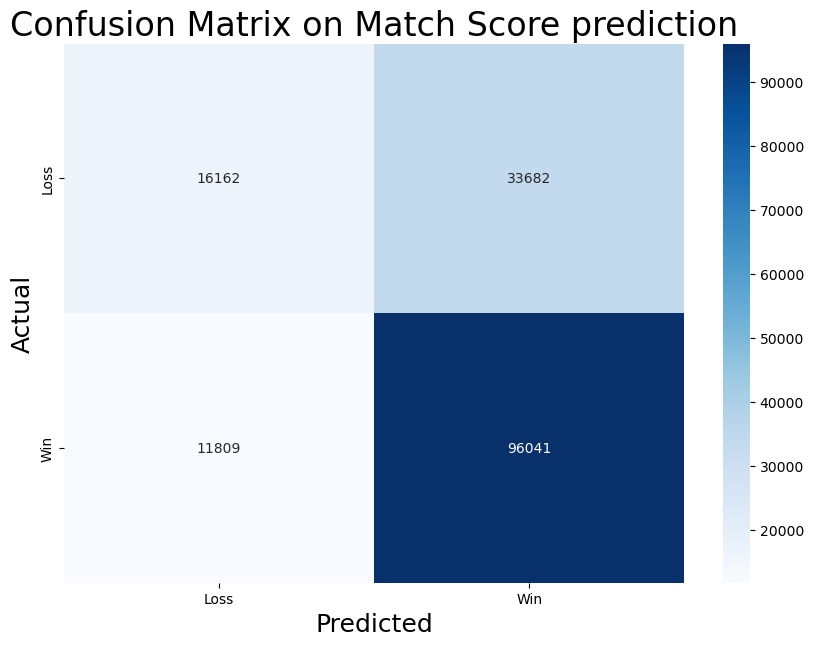

In [40]:
# Set the labels for the confusion matrix
class_labels = ['Loss', 'Win']

# Create a pandas DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(confusionMatrix, index=class_labels, columns=class_labels)

# Plot using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix on Match Score prediction', fontsize=24)
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.show()

Three most popular teams are chosen to retrieve the comments of their fans on a matchday, and the match result of the team on that day are also recorded. The figure here shows the cleaned comments text body along with the comments' score as input features, where the training and predicting labels are the outcome of the match on the day the comments were made. Prior to the actual machine learning section, a few preparations are done on this dataset, including vectorizing the text bodies using tokenizer and hashing into a new feature, transforming the outcomes into 1s (win) and 0s (loss), and combining the new feature and the score of each comment into the correct traning feature.

Since only 2 outcome: win or loss are used in this machine learning study, logistic regression is the model to be trained. After the model is trained on the comment scores and the vectorized comments texts, it can then predict on the testing features. According the results of the measurements, the accuracy, precision and recall of the predictions compared to the testing labels are all around 0.7, which is a bit disappointing for a binary classification learning. According to the confusion matrix, it seems that the model is good at predicting actual wins, however when predicting losses the performance is not quite good. Thus we can conclude that the model can moderately tell the outcome of a match based on the comments and their scores.